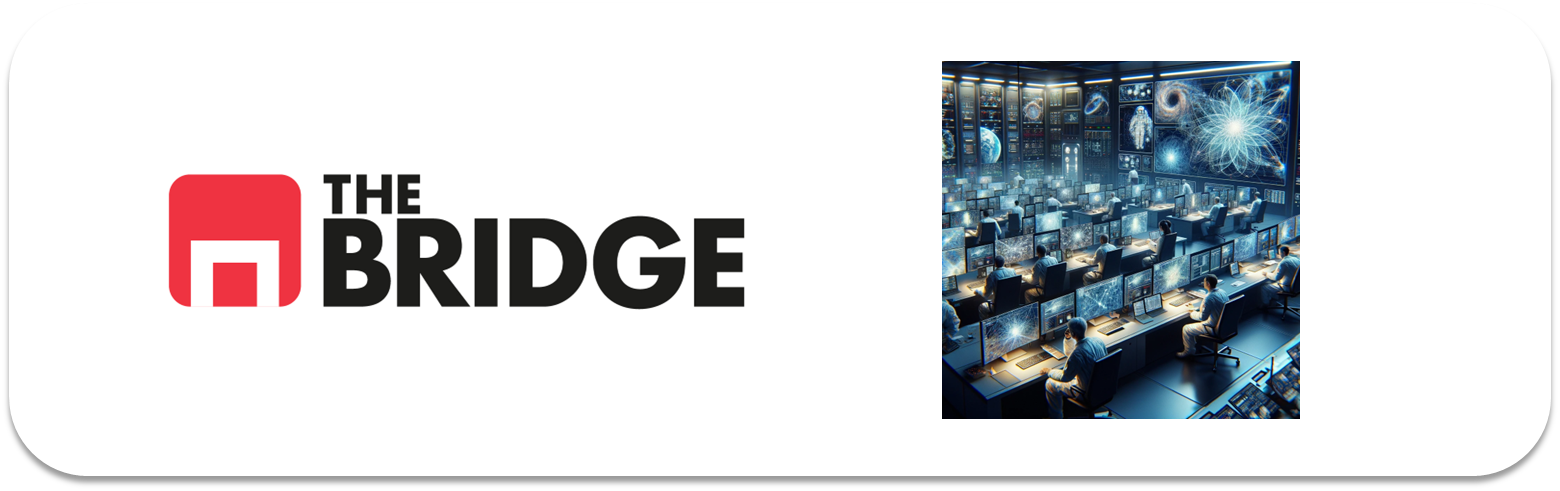

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import cv2
from cv2 import imread
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# deep learning
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential # De aquí sacamos el tipo de modelo que vamos a construir, que sigue siendo una secuencia o cadena de capas consecutivas
from keras.layers import Conv2D # Esta es la capa para convolucionales con entrada de 2 dimensiones
from keras.layers import MaxPool2D # Esta es la clase que corresponde a las capas de Pooling que hacen maxpooling sobre datos de entrada en 2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



##### 0. Cargar y visualizar datos

In [2]:
root_path = './data/'

train_path = root_path + 'seg_train/'
test_path = root_path + 'seg_test/'

def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 224 x 224

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [3]:
X_train, y_train = read_data(train_path)

In [4]:
X_test, y_test = read_data(test_path)

In [5]:
def visualize_images(X, y, num_images=10):
    if len(X) == 0:
        print("No hay imágenes para mostrar.")
        return
    
    num_images = min(num_images, len(X))  # Asegurar que no se exceda el número de imágenes disponibles
    indices = np.random.choice(len(X), num_images, replace=False)  # Seleccionar imágenes aleatorias
    
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB para visualización correcta
        plt.title(y[idx])
        plt.axis('off')
    plt.show()

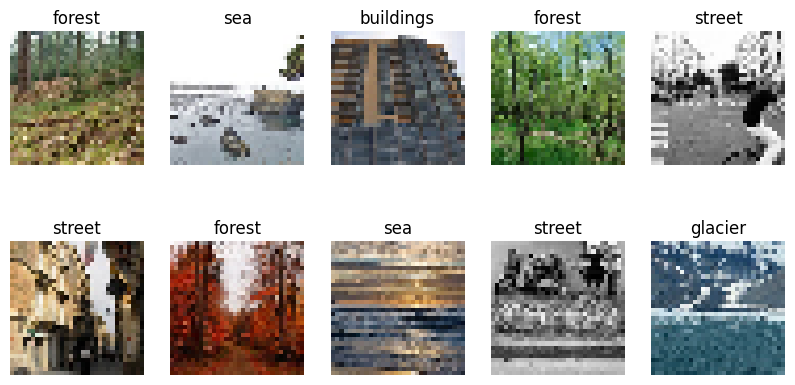

In [6]:
visualize_images(X_train,y_train,10)

In [7]:
np.isnan(X_train).any() # Comprobar si hay valores nulos en el conjunto de entrenamiento

False

In [8]:
pd.DataFrame(y_train).value_counts() # 6 clases

0        
mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
Name: count, dtype: int64

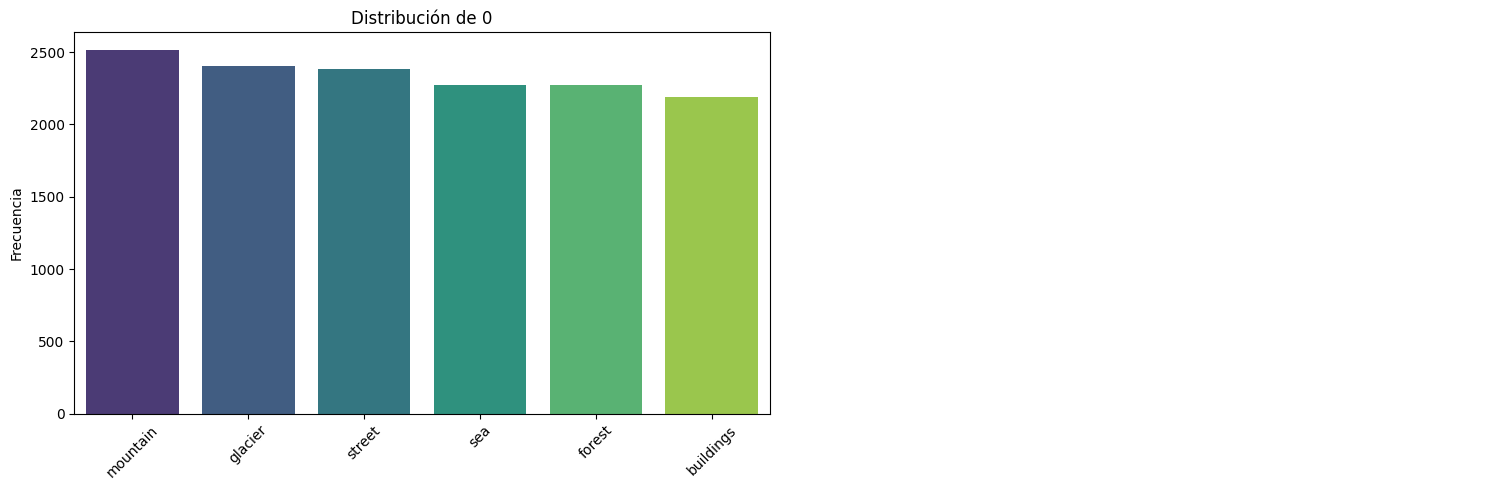

In [11]:
bt.pinta_distribucion_categoricas(pd.DataFrame(y_train), pd.DataFrame(y_train).columns)

In [9]:
X_train.shape

(14034, 32, 32, 3)

In [10]:
# normalización de las imágenes
X_train = X_train / 255.0   # normalizamos los valores de los píxeles entre 0 y 1
X_test = X_test / 255.0

In [11]:
X_train[0,:,:,0]

array([[0.96078431, 0.96470588, 0.96470588, ..., 0.97254902, 0.98039216,
        0.96862745],
       [0.96470588, 0.96470588, 0.96470588, ..., 0.98823529, 0.98431373,
        0.97647059],
       [0.98039216, 0.97254902, 0.97647059, ..., 0.99215686, 0.98823529,
        0.98823529],
       ...,
       [0.26666667, 0.30588235, 0.16078431, ..., 0.10980392, 0.2       ,
        0.30196078],
       [0.27843137, 0.2627451 , 0.36470588, ..., 0.30980392, 0.24705882,
        0.27843137],
       [0.18431373, 0.23529412, 0.19607843, ..., 0.17254902, 0.18431373,
        0.14901961]])

In [12]:
# shuffle
from sklearn.utils import shuffle
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train, random_state=42)

In [13]:
# transformar y_train e y_test a enteros con LabelEncoder
le = LabelEncoder()
y_train_shuffle = le.fit_transform(y_train_shuffle)
y_test = le.transform(y_test)

In [15]:
np.unique(y_train_shuffle)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [16]:
labels_dict = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

##### 1. Diseñar arquitectura de la red para Transfer Learning

In [29]:
# importar el modelo VGG19
from tensorflow.keras.applications import VGG19

# Obtener número de clases automáticamente
num_classes = len(np.unique(y_train))

# definir el modelo base con los pesos
base_model = VGG19(input_shape=(32, 32,3),
                        include_top=False, # no consideramos las capas densas
                        weights="imagenet") # Se carga con los pesos entrenados para el dataset de imagenet)

# congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False   

# crear la cabeza con dos capas densas

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 300 hidden units and ReLU activation
x = layers.Dense(300, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [27]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │       153,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300)            │             

 Total params: 20,180,090 (76.98 MB)

 Trainable params: 155,706 (608.23 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

##### 2. Entrenar el modelo

In [23]:
X_train_shuffle.shape

(14034, 32, 32, 3)

In [24]:
print(y_train.dtype)

<U9


In [30]:
# Entrenar
history = model.fit(X_train_shuffle,y_train_shuffle,
                    validation_split = 0.2,
                    steps_per_epoch = 100, # Cantidad de batches en los que divide el epoch
                    epochs = 10)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 356ms/step - accuracy: 0.4713 - loss: 1.3698 - val_accuracy: 0.6950 - val_loss: 0.8340
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6950 - val_loss: 0.8340
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 419ms/step - accuracy: 0.6830 - loss: 0.8654 - val_accuracy: 0.7232 - val_loss: 0.7536
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7232 - val_loss: 0.7536
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 403ms/step - accuracy: 0.7123 - loss: 0.7940 - val_accuracy: 0.7321 - val_loss: 0.7172
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7321 - val_loss: 0.7172
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 420ms/step - accuracy: 0.7278 - loss: 0.7478 - val_accuracy: 0.7456 - val_loss: 0.7056
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accura

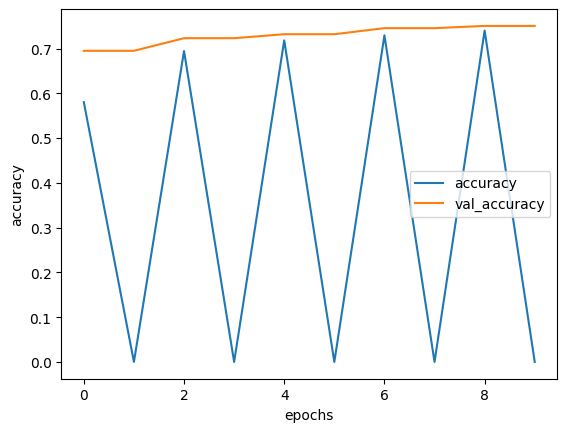

In [32]:
history_df = pd.DataFrame(history.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

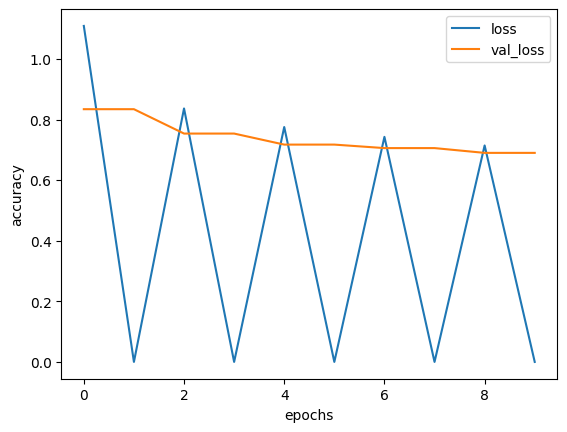

In [33]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

In [34]:
# Entrenar
history_2 = model.fit(X_train_shuffle,y_train_shuffle,
                    validation_split = 0.2,
                    batch_size = 128, 
                    steps_per_epoch = 110, # nº muestras (1403) / batch size (128)
                    epochs = 10)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 31s 283ms/step - accuracy: 0.7462 - loss: 0.6931 - val_accuracy: 0.7506 - val_loss: 0.6827
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 335ms/step - accuracy: 0.7548 - loss: 0.6701 - val_accuracy: 0.7570 - val_loss: 0.6649
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 327ms/step - accuracy: 0.7597 - loss: 0.6548 - val_accuracy: 0.7549 - val_loss: 0.6602
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 335ms/step - accuracy: 0.7603 - loss: 0.6514 - val_accuracy: 0.7670 - val_loss: 0.6495
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 322ms/step - accuracy: 0.7666 - loss: 0.6362 - val_accuracy: 0.7652 - val_loss: 0.6596
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 320ms/step - accuracy: 0.7698 - loss: 0.6353 - val_accuracy: 0.7652 - val_loss: 0.6455
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/step - accuracy: 0.7710 - loss: 0.6311 - val_accuracy: 0.7624 - val_loss: 0.6545
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 321ms/step - accuracy: 0.7784 - loss: 0

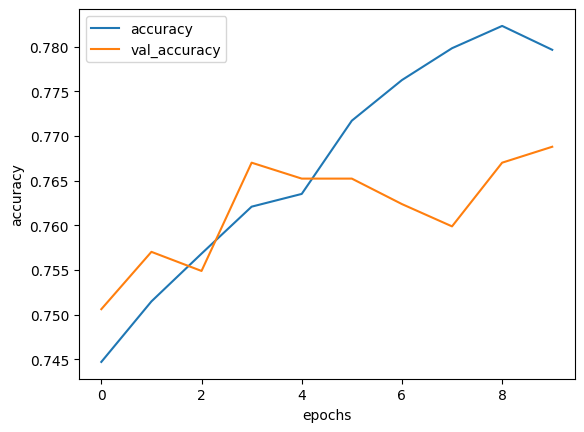

In [39]:
history_df = pd.DataFrame(history_2.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

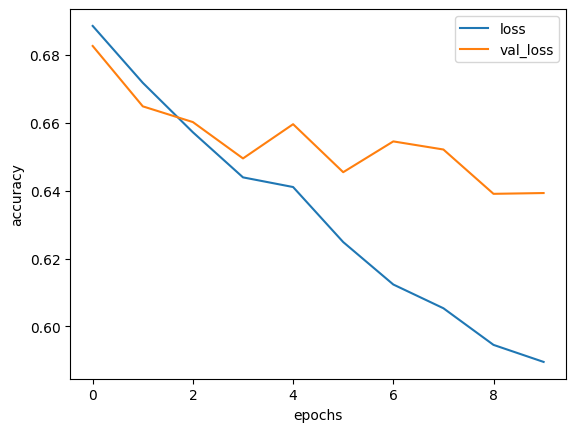

In [40]:
history_df = pd.DataFrame(history_2.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

##### 3. Evaluar el modelo

In [35]:
model.evaluate(X_test,y_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.7400 - loss: 0.6821


[0.6657394766807556, 0.7525632381439209]

In [ ]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step


In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       363
           1       0.91      0.89      0.90       474
           2       0.69      0.73      0.71       553
           3       0.75      0.64      0.69       525
           4       0.71      0.74      0.73       510
           5       0.73      0.82      0.78       501

    accuracy                           0.75      2926
   macro avg       0.76      0.75      0.75      2926
weighted avg       0.75      0.75      0.75      2926



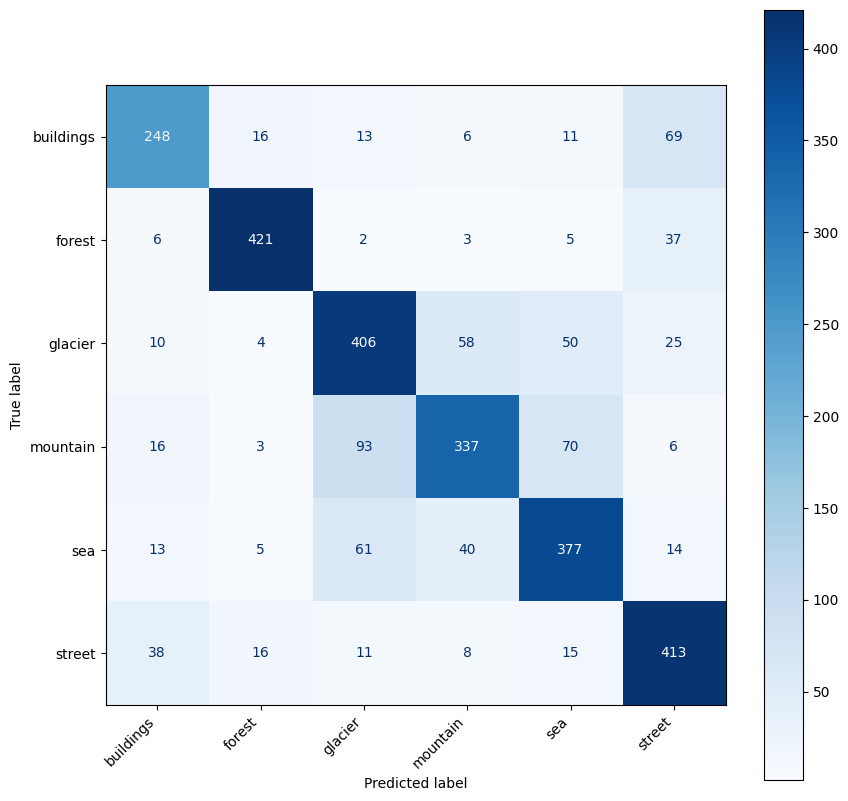

In [38]:
from sklearn.metrics import confusion_matrix
# Mostrar matriz de confusión con etiquetas reales
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels_dict.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

##### 4. Diseñar arquitectura de la red para Fine Tuning

In [46]:
# definir el modelo base sin los pesos
base_model = VGG19(input_shape=(32, 32,3),
                        include_top=False, # no consideramos las capas densas
                        weights=None) # Se carga sin los pesos

# crear la cabeza con dos capas densas
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 300 hidden units and ReLU activation
x = layers.Dense(300, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [44]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 300)            │       153,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 300)            │             

 Total params: 20,180,090 (76.98 MB)

 Trainable params: 20,180,090 (76.98 MB)

 Non-trainable params: 0 (0.00 B)

##### 5. Entrenar el modelo

In [47]:
# Entrenar
history_2 = model.fit(X_train_shuffle,y_train_shuffle,
                    validation_split = 0.2,
                    batch_size = 128, 
                    steps_per_epoch = 110, # nº muestras (1403) / batch size (128)
                    epochs = 10)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.1755 - loss: 4.2488 - val_accuracy: 0.1831 - val_loss: 1.7905
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.1696 - loss: 1.7875 - val_accuracy: 0.1831 - val_loss: 1.7905
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.1805 - loss: 1.7870 - val_accuracy: 0.1831 - val_loss: 1.7907
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.1784 - loss: 1.7878 - val_accuracy: 0.1689 - val_loss: 1.7910
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.1730 - loss: 1.7871 - val_accuracy: 0.1831 - val_loss: 1.7907
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.1791 - loss: 1.7868 - val_accuracy: 0.1831 - val_loss: 1.7908
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.1766 - loss: 1.7866 - val_accuracy: 0.1831 - val_loss: 1.7907
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.1795 - loss: 1.7869 - val_accu

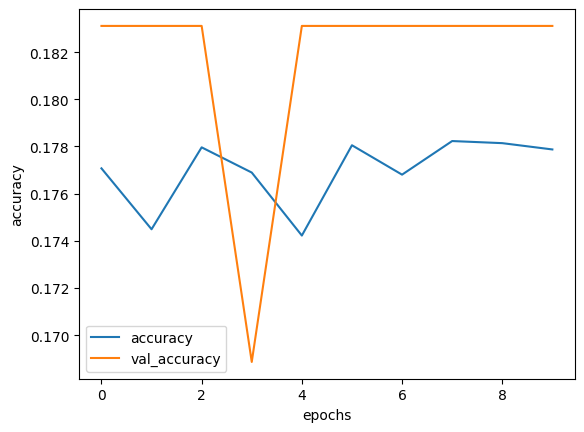

In [48]:
history_df = pd.DataFrame(history_2.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

In [ ]:
history_df = pd.DataFrame(history_2.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

##### 6. Evaluar el modelo

In [49]:
model.evaluate(X_test,y_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.1055 - loss: 1.8047


[1.7889888286590576, 0.17942583560943604]

In [50]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step


In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       363
           1       0.00      0.00      0.00       474
           2       0.00      0.00      0.00       553
           3       0.18      1.00      0.30       525
           4       0.00      0.00      0.00       510
           5       0.00      0.00      0.00       501

    accuracy                           0.18      2926
   macro avg       0.03      0.17      0.05      2926
weighted avg       0.03      0.18      0.05      2926



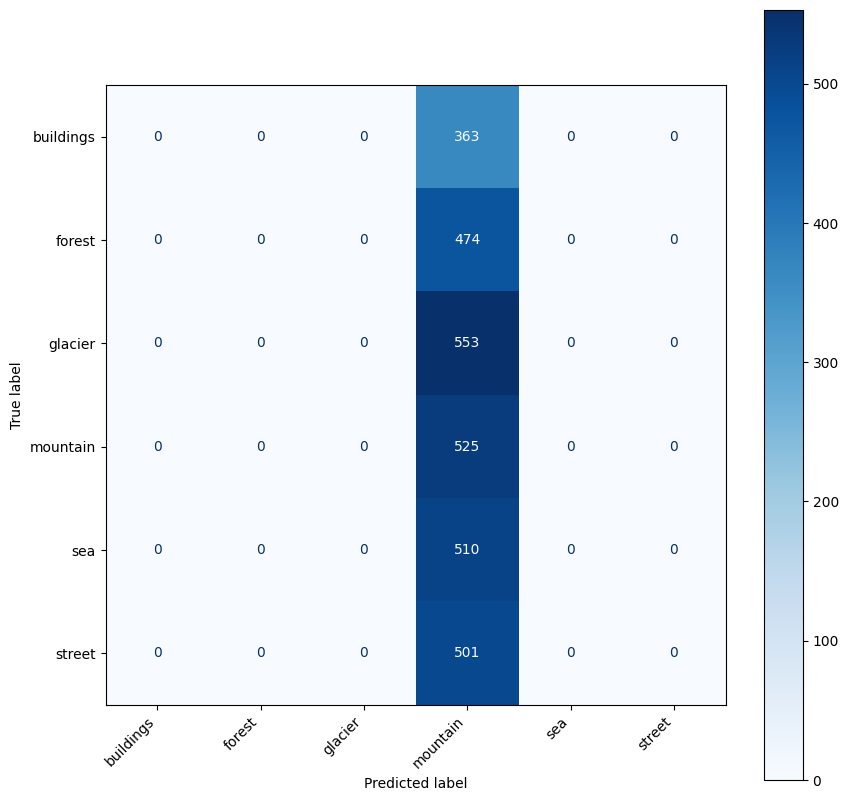

In [52]:
from sklearn.metrics import confusion_matrix
# Mostrar matriz de confusión con etiquetas reales
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels_dict.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()